In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import gaussian_kde
from flaml import AutoML
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from catboost import CatBoostRegressor
from mpl_toolkits.axes_grid1 import make_axes_locatable

import shap

/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
!hostname

keeling-gpu09


In [14]:
def calculate_metrics_and_plot_single(y_true, y_pred, var):
    # Calculate R2, RMSE, MAE
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Print the calculated metrics
    print(f'MSE:{mse}')
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    # Calculate point density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    # Plot y_true vs y_pred density scatter plot
    plt.figure(figsize=(8, 7))

    scatter = plt.scatter(y_true, y_pred, c=z, s=20, cmap='rainbow')

    # Create color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=17)  # Set the color bar label and fontsize
    cbar.ax.tick_params(labelsize=16)  # Set the font size for the color bar ticks

    # Plot a reference line (ideal prediction line y_true = y_pred)
    # plt.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    # plt.xlim(1e5, 1e12)
    # plt.ylim(1e5, 1e12)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel(f'Actual {var}', fontsize=17)
    plt.ylabel(f'Predicted {var}', fontsize=17)
    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                    grid_color='gray', grid_alpha=0.7, labelsize=16)

    # Annotate with the metrics in the top left corner
    # metrics_text = f'R$^2$: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}'
    metrics_text = f'R$^2$: {r2:.2f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=14,  # Adjust the font size
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.5'))

    # plt.title('Actual vs Predicted Scatter Plot with Density', fontsize=15)
    plt.grid(True)
    plt.show()

In [3]:
def calculate_metrics_and_plot(ax, y_true, y_pred, var):
    # Calculate metrics
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    scatter = ax.scatter(y_true, y_pred, c=z, s=20, cmap='rainbow')
    
    # Reference line
    ax.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    ax.set_xlim(1e5, 1e12)
    ax.set_ylim(1e5, 1e12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'Actual {var}', fontsize=12)
    ax.set_ylabel(f'Predicted {var}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # metrics_text = f'R$^2$: {r2:.2f}'
    metrics_text = f'R$^2$: {r2:.4f}\nMAPE: {mape * 100:.2f}%'
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    
    return scatter

In [ ]:
PartMC_data = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/merged_data.csv')

columns_to_multiply = ['SO4', 'NaCl', 'OIN', 'OC', 'BC', 'SOA']
columns_to_divide = ['CCN_VS_0.1', 'CCN_VS_0.3', 'CCN_VS_0.6', 'CCN_VS_1.0', 'CCN_CS_0.1', 'CCN_CS_0.3', 'CCN_CS_0.6', 'CCN_CS_1.0','Num_Conc']
PartMC_data[columns_to_multiply] = PartMC_data[columns_to_multiply] * 1e9 # Convert to ug/m3
PartMC_data[columns_to_divide] = PartMC_data[columns_to_divide] * 1e-6 # Convert to #/cm3 
PartMC_data['Bulk_DP'] = PartMC_data['Bulk_DP']*1e6 # convert to um

In [5]:
PartMC_data.head()

,Global_ID,DayofYear,Time_hr,Temperature,RH,Density,Bulk_DP,BC,OC,OIN,...,SOA,Num_Conc,CCN_CS_0.1,CCN_CS_0.3,CCN_CS_0.6,CCN_CS_1.0,CCN_VS_0.1,CCN_VS_0.3,CCN_VS_0.6,CCN_VS_1.0
0,1,116,1,283.512,0.5398,1.228736,0.152147,0.082128,14.849793,0.227778,...,0.001546,181.651772,6.481069,24.377317,167.360419,588.547388,23.848988,492.672866,928.176213,976.198858
1,1,116,2,283.512,0.5398,1.228736,0.159248,0.119528,22.459556,0.340804,...,0.010701,269.546679,26.141075,901.398986,1371.430280,1440.314202,857.942037,1414.710985,1449.170547,1451.504474
2,1,116,3,283.512,0.5398,1.228736,0.178122,0.134639,26.319633,0.400331,...,0.028724,311.366470,404.705493,1538.508614,1634.317752,1670.916704,1201.571914,1658.121891,1675.353396,1675.757065
3,1,116,4,283.512,0.5398,1.228736,0.195206,0.155056,29.973418,0.463913,...,0.057649,364.848062,1037.259008,1836.729836,1945.227180,1963.046416,1558.552904,1956.104422,1962.651506,1964.038677
4,1,116,5,283.512,0.5398,1.228736,0.209752,0.185635,36.333209,0.558799,...,0.108710,445.723762,1546.940851,2265.587079,2380.872339,2398.872672,2056.623398,2388.665616,2399.552885,2399.856498


In [6]:
missing_values = PartMC_data.isnull().sum()
print(missing_values)

Global_ID      0
DayofYear      0
Time_hr        0
Temperature    0
RH             0
Density        0
Bulk_DP        0
BC             0
OC             0
OIN            0
NaCl           0
SO4            0
SOA            0
Num_Conc       0
CCN_CS_0.1     0
CCN_CS_0.3     0
CCN_CS_0.6     0
CCN_CS_1.0     0
CCN_VS_0.1     0
CCN_VS_0.3     0
CCN_VS_0.6     0
CCN_VS_1.0     0
dtype: int64


In [7]:
splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(PartMC_data, groups=PartMC_data['Global_ID']))

train, test = PartMC_data.iloc[train_idxs], PartMC_data.iloc[test_idxs]

In [8]:
train_ids = set(train['Global_ID'])
test_ids = set(test['Global_ID'])

overlap_ids = train_ids.intersection(test_ids)

if overlap_ids:
    print("Error: The following Global_ID are found in both training and testing sets:", overlap_ids)
else:
    print("Success: No Global_ID are split between training and testing sets.")

Success: No Global_ID are split between training and testing sets.


In [9]:
# input_list = ['temperature','relative_humidity','so2','no2','no','nh3','co','ch3oh','ald2','anol','aone','dms','eth','hcho','isop','olei','olet','par','tol','xyl','so4','no3','cl','nh4','co3','na','ca','oin','oc','bc','h2o']
input_list = ['Temperature','RH','Density','Bulk_DP','Num_Conc','SO4', 'NaCl', 'OIN', 'OC', 'BC', 'SOA']
# output_list = ['ccn_vs_01']

# X_train = train[input_list]
# y_train = train[output_list].squeeze()
# X_test = test[input_list]
# y_test = test[output_list].squeeze()

In [ ]:
output_list = ['CCN_VS_0.1', 'CCN_VS_0.3', 'CCN_VS_0.6', 'CCN_VS_1.0']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, output in enumerate(output_list):
    X_train = train[input_list]
    y_train = train[output].squeeze()
    X_test = test[input_list]
    y_test = test[output].squeeze()

    automl = AutoML(random_state=42)
    n_jobs = 16
    time_budget = 1800 # in seconds

    automl_settings = {
        "time_budget": time_budget,  
        "metric": 'mape',  # Metric used to evaluate the models
        "task": 'regression',  
        "eval_method": "cv",  
        "n_splits": 5,  
        "estimator_list": [  
            'xgboost', 
            'xgb_limitdepth', 
            'rf', 
            'lgbm', 
            'catboost', 
            'extra_tree', 
            'histgb', 
        ],
        "n_jobs": n_jobs,  
        "log_file_name": f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output}.log',  
    }

    automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
    joblib.dump(automl, f"/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output}.pkl")
    
    var = f'CCN$_{{{output[-3:]}}}$'
        
    y_test_pred = automl.predict(X_test)
    scatter = calculate_metrics_and_plot(axes[i], y_test*1e6, y_test_pred*1e6, var)

fig.subplots_adjust(right=0.88)  # Shrink figure a bit to make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap
plt.show()

In [11]:
# ['xgboost', 'xgb_limitdepth', 'rf', 'lgbm', 'lgbm_spark', 'rf_spark', 'lrl1', 'lrl2', 'catboost', 'extra_tree', 'kneighbor', 'transformer', 'transformer_ms', 'histgb', 'svc', 'sgd', 'nb_spark', 'enet', 'lassolars', 'glr_spark', 'lr_spark', 'svc_spark', 'gbt_spark', 'aft_spark']

# load model

In [11]:
PartMC_data = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/merged_data.csv')

columns_to_multiply = ['SO4', 'NaCl', 'OIN', 'OC', 'BC', 'SOA']
columns_to_divide = ['CCN_VS_0.1', 'CCN_VS_0.3', 'CCN_VS_0.6', 'CCN_VS_1.0', 'CCN_CS_0.1', 'CCN_CS_0.3', 'CCN_CS_0.6', 'CCN_CS_1.0','Num_Conc']
PartMC_data[columns_to_multiply] = PartMC_data[columns_to_multiply] * 1e9 # Convert to ug/m3
PartMC_data[columns_to_divide] = PartMC_data[columns_to_divide] * 1e-6 # Convert to /cm-3 
PartMC_data['Bulk_DP'] = PartMC_data['Bulk_DP']*1e6 # convert to um

splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(PartMC_data, groups=PartMC_data['Global_ID']))

train, test = PartMC_data.iloc[train_idxs], PartMC_data.iloc[test_idxs]

input_list = ['Temperature','RH','Density','Bulk_DP','Num_Conc','SO4', 'NaCl', 'OIN', 'OC', 'BC', 'SOA']

feature_names = ['T', 'RH', r'$\rho_{air}$',r'$\rm D_p$',r'$\rm N_t$',r'$\rm SO_4$','NaCl', 'Dust', 'OC', 'BC', 'SOA']

In [22]:
PartMC_data.head()

,Global_ID,DayofYear,Time_hr,Temperature,RH,Density,Bulk_DP,BC,OC,OIN,...,SOA,Num_Conc,CCN_CS_0.1,CCN_CS_0.3,CCN_CS_0.6,CCN_CS_1.0,CCN_VS_0.1,CCN_VS_0.3,CCN_VS_0.6,CCN_VS_1.0
0,1,116,1,283.512,0.5398,1.228736,0.152147,0.082128,14.849793,0.227778,...,0.001546,181.651772,6.481069,24.377317,167.360419,588.547388,23.848988,492.672866,928.176213,976.198858
1,1,116,2,283.512,0.5398,1.228736,0.159248,0.119528,22.459556,0.340804,...,0.010701,269.546679,26.141075,901.398986,1371.430280,1440.314202,857.942037,1414.710985,1449.170547,1451.504474
2,1,116,3,283.512,0.5398,1.228736,0.178122,0.134639,26.319633,0.400331,...,0.028724,311.366470,404.705493,1538.508614,1634.317752,1670.916704,1201.571914,1658.121891,1675.353396,1675.757065
3,1,116,4,283.512,0.5398,1.228736,0.195206,0.155056,29.973418,0.463913,...,0.057649,364.848062,1037.259008,1836.729836,1945.227180,1963.046416,1558.552904,1956.104422,1962.651506,1964.038677
4,1,116,5,283.512,0.5398,1.228736,0.209752,0.185635,36.333209,0.558799,...,0.108710,445.723762,1546.940851,2265.587079,2380.872339,2398.872672,2056.623398,2388.665616,2399.552885,2399.856498


/tmp/ipykernel_5691/1656526293.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap


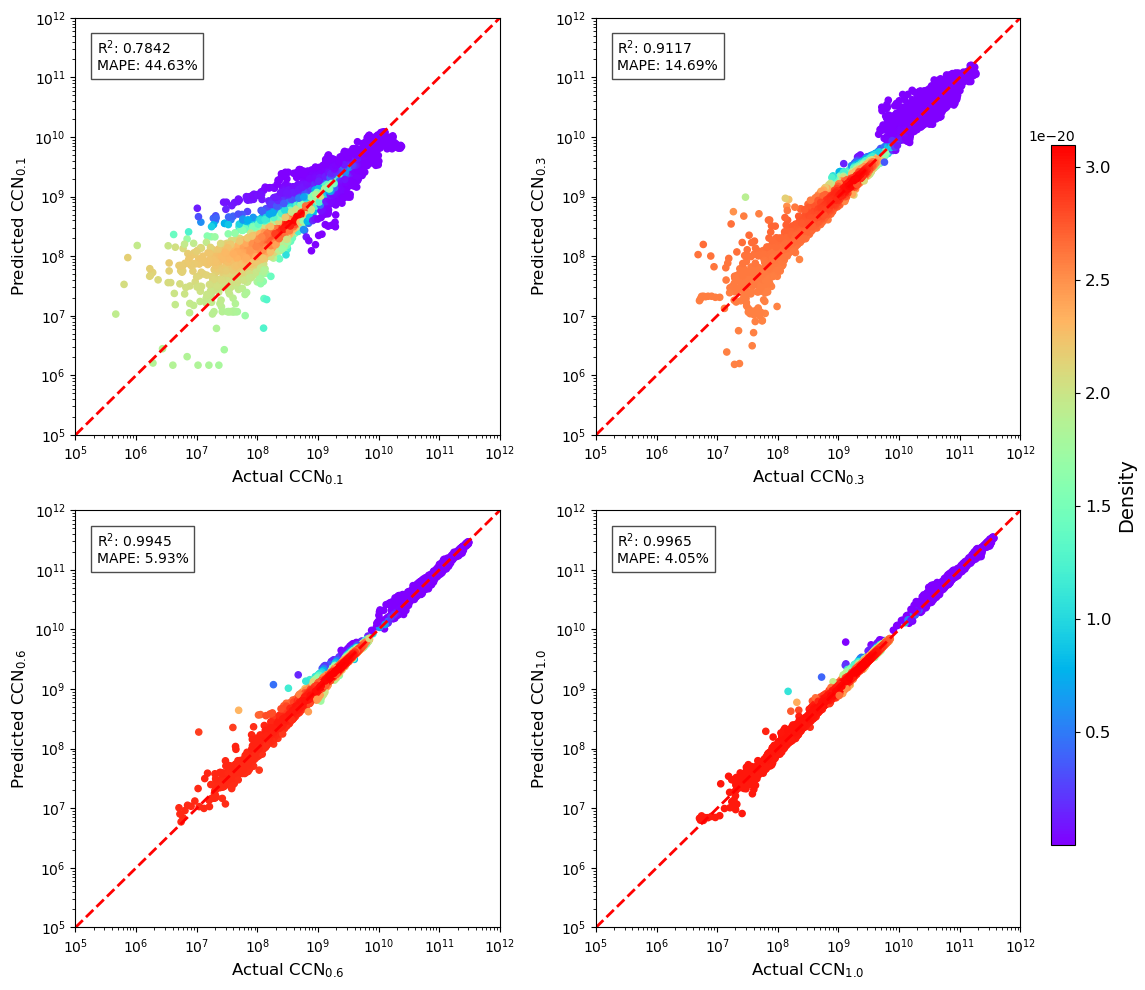

In [13]:
output_list = ['CCN_VS_0.1', 'CCN_VS_0.3', 'CCN_VS_0.6', 'CCN_VS_1.0']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, output in enumerate(output_list):
    with open(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output_list[i]}.pkl', 'rb') as f:    
        automl = joblib.load(f)
    X_train = train[input_list]
    y_train = train[output].squeeze()
    X_test = test[input_list]
    y_test = test[output].squeeze()
    
    var = f'CCN$_{{{output[-3:]}}}$'
        
    y_test_pred = automl.predict(X_test)
    scatter = calculate_metrics_and_plot(axes[i], y_test*1e6, y_test_pred*1e6, var)

fig.subplots_adjust(right=0.88)  # Shrink figure a bit to make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap
plt.show()

In [29]:
automl = joblib.load(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_CCN_VS_1.0.pkl')
estimator = automl.model.estimator

X_test = test[input_list]

if isinstance(estimator, CatBoostRegressor):
    explainer = shap.TreeExplainer(estimator, feature_perturbation='tree_path_dependent')

    X_test_sample = X_test.sample(n=1000, random_state=42)
    shap_values_sample = explainer(X_test_sample, check_additivity=False)
    
else: #isinstance(estimator, ExtraTreesRegressor):
    explainer = shap.TreeExplainer(estimator)

    X_test_sample = X_test.sample(n=1000, random_state=42)
    shap_values_sample = explainer(X_test_sample, check_additivity=False)
    
# else:
#     print("estimator 既不是 CatBoostRegressor，也不是 ExtraTreesRegressor")

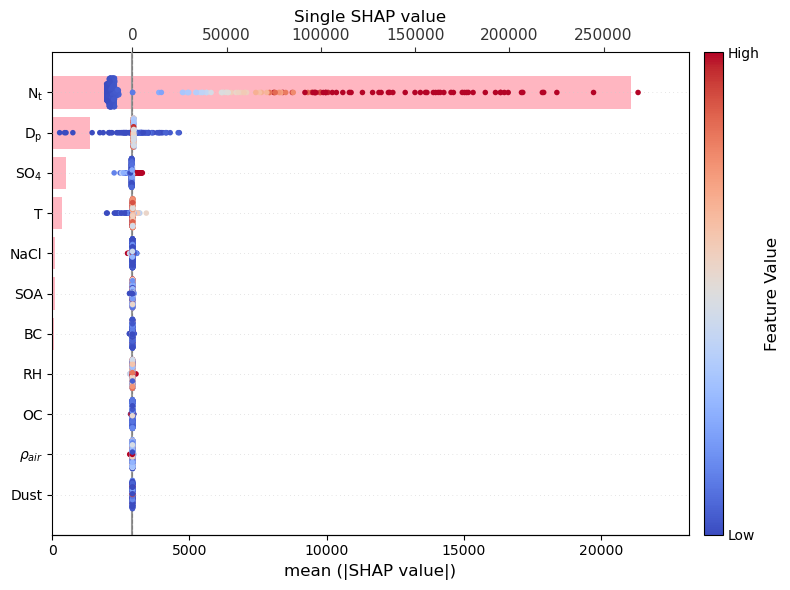

In [30]:
# 1) 计算 & 排序（降序）
shap_arr      = shap_values_sample.values
mean_abs_shap = np.abs(shap_arr).mean(axis=0)
order         = np.argsort(mean_abs_shap)[::-1]   # highest first
labels        = [feature_names[i] for i in order]

# 2) 准备倒序的 y 位置
N = len(order)
y_positions = np.arange(N)[::-1]

# 3) 重排 Explanation 对象
shap_bees = shap_values_sample[:, order]

# 4) 创建图和双 X 轴
fig, ax_bar    = plt.subplots(figsize=(8,6))
ax_scatter     = ax_bar.twiny()

# 5) 在倒序 y_positions 上画水平柱状图
ax_bar.barh(
    y_positions,
    mean_abs_shap[order],
    color='lightpink',
    edgecolor='none'
)

# 6) 在相同 y_positions 上画 beeswarm
#    beeswarm 本身会 jitter y，所以我们先画空点仅占位置：
for yi in y_positions:
    ax_scatter.plot([], [])  # 占位，不影响

shap.plots.beeswarm(
    shap_bees,
    ax=ax_scatter,
    show=False,
    plot_size=None,
    color_bar=False,
    color=plt.get_cmap("coolwarm"),
    max_display=None
)

# 7) 画上方 x=0 竖线
ax_scatter.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# 8) 设置坐标轴范围和位置
ax_bar.set_xlim(0, mean_abs_shap.max()*1.1)
ax_scatter.set_xlim(shap_arr.min()*1.1, shap_arr.max()*1.1)

ax_bar.xaxis.set_ticks_position('bottom')
ax_bar.xaxis.set_label_position('bottom')
ax_scatter.xaxis.set_ticks_position('top')
ax_scatter.xaxis.set_label_position('top')

# 9) 只在 ax_bar 上设置 y 轴标签
ax_bar.set_yticks(y_positions)
ax_bar.set_yticklabels(labels, fontsize=10)

# 显式打开 ax_bar 的左侧 ticks 和 ticklabels
ax_bar.tick_params(axis='y', which='both', left=True, labelleft=True)

# 关闭 ax_scatter 的 y 轴
ax_scatter.yaxis.set_visible(False)

# # 10) 清掉 ax_scatter 的 y 轴刻度
# ax_scatter.set_yticks([])
# ax_scatter.set_yticklabels([])

ax_bar.set_xlabel("mean (|SHAP value|)", fontsize=12)
ax_scatter.set_xlabel("Single SHAP value", fontsize=12)

# 11) 外置 Low–High colorbar
sc = ax_scatter.collections[-1]
divider = make_axes_locatable(ax_scatter)
cax     = divider.append_axes("right", size="3%", pad=0.15)
cbar    = fig.colorbar(sc, cax=cax, orientation='vertical')
vmin, vmax = sc.norm.vmin, sc.norm.vmax
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low','High'])
cbar.set_label("Feature Value", fontsize=12)
cbar.ax.tick_params(size=0)

plt.tight_layout()
plt.show()